# Homework 4: Neural Networks

Complete the following questions and resubmit this entire notebook to canvas.
- For questions that ask you to derive or find a quantity use a __text cell__ to show your calculations.
 - Use markdown to write math expressions (as was done to create these problems) and make sure to show your work.
 - It doesnt have to be perfect looking but it needs to be readible.
 - You may also submit a legible picture of your derivation
- For questions that ask you compute something or write code use a __code cell__ to write your code.
 - You can create additional code cells as needed.
 - Just make sure your code is commented, the functions are named appropriately, and its easy to see your final answer.
- The total points on this homework is 120. Out of these 5 points are reserved for clarity of presentation,
punctuation and commenting with respect to the code.

__SUBMISSION__

When you submit you will submit a pdf file __and__ the notebook file. The TA will use the pdf file to grade more quickly. The notebook file is there to confirm your work.

To generate a pdf file
1. Click File
2. Click print
3. Set the destinationas "save as pdf"
4. Hit print


Title the pdf file `LASTNAME-FIRSTNAME-HW4.pdf`
Title your notebook file as `LASTNAME-FIRSTNAME-HW4.ipynb`

Submit both files.




Additional Notes: You may try the following methods if you have any trouble for printing

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
#!pip install nbconvert
#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
#!jupyter nbconvert --to pdf /content/drive/MyDrive/STAT421_2025Spring/STAT421_25Spring_Homework/Homework4/hw4.ipynb

In [3]:
# Alternatively if you want to do it on your own laptop
# 1. Download hw4.ipynb to your laptop
# 2. Make sure you have installed Jupyter Notebook or Jupyter Lab. If not,
#    pip install jupyterlab
# 3. Run the code below on your labtop
#    jupyter nbconvert --to pdf hw4.ipynb

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize

from sklearn import metrics
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import warnings
warnings.filterwarnings('ignore')

# Question 1 - plotting (10 points)

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes (3 channels), with 6000 images per class. There are 50000 training images and 10000 test images. https://www.cs.toronto.edu/~kriz/cifar.html

As a machine learner we test out new algorithms by __benchmarking__ them on standard datasets. CIFAR10 was one of the most commonly used benchmarking datasets for image classifiers before being superceded by much larger and more comprehensive datasets.

Lets benchmark some of the algorithms we have learned on this dataset.

Use the following code to download the data. If you are on google colab you will not need to install any new packages and you can just run the code. If you are not on google colab then install the following packages with

`pip3 install torch torchvision torchaudio`

and then run the code.

In [5]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170M/170M [00:02<00:00, 77.8MB/s]


In [6]:
training_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
# Train on the first 20000 images
# Test on the last 10000 images

from torch.utils.data import Subset
train_data = Subset(training_data, np.arange(0, 20000))
test_data = Subset(training_data, np.arange(40000, 50000))


## part 1 - EDA

First lets see what were working with. Create a 10x10 array of plots, where each row is a class with 10 example images from that class. For example, row 1 has 10 pictures of airplanes, row 2 has 10 pictures of automobiles, etc. Make sure to include the class name for each row.

Basically just recreate the figure from https://www.cs.toronto.edu/~kriz/cifar.html


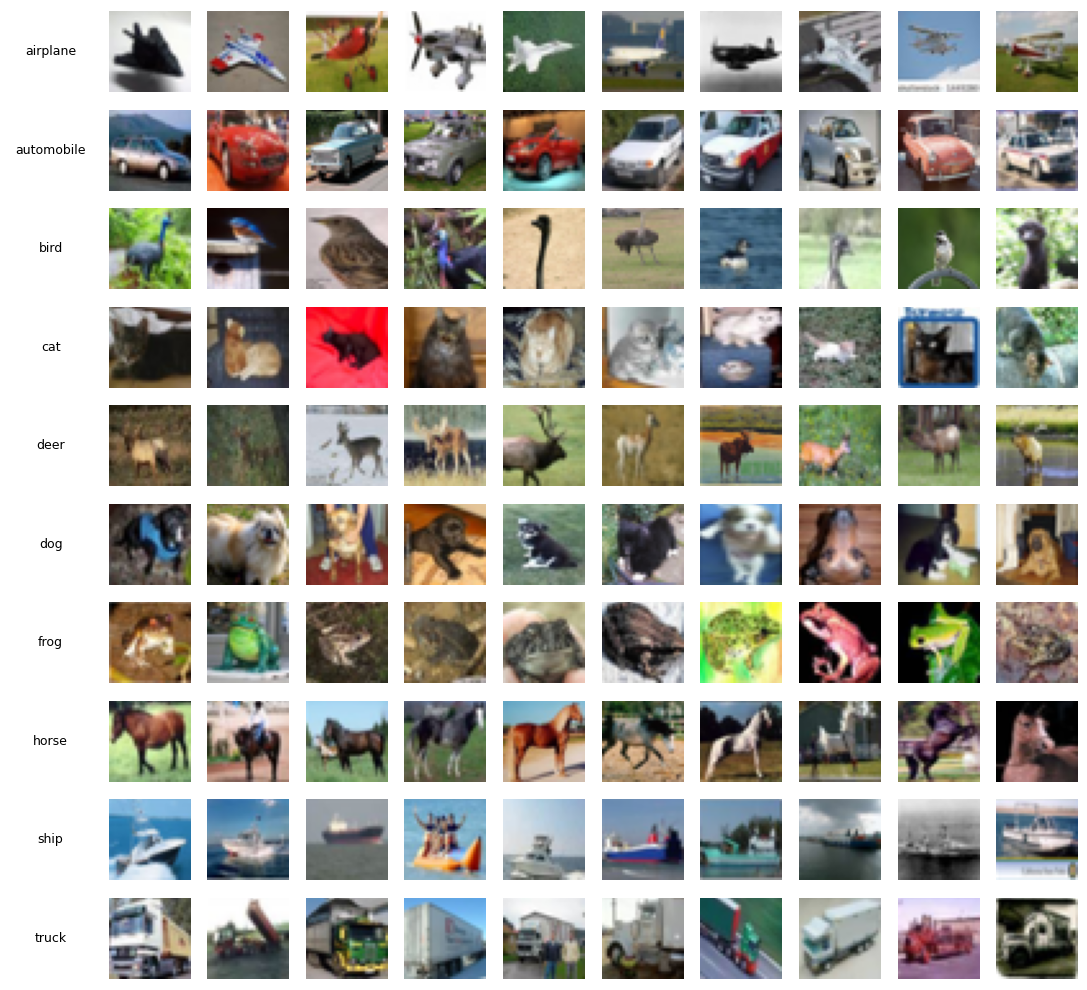

In [8]:
# plot goes here
class_names = training_data.classes

images_by_class = {cls: [] for cls in class_names}

for img, label in training_data:
  class_name = class_names[label]
  if len(images_by_class[class_name]) < 10:
    images_by_class[class_name].append(img)
  if all(len(imgs) == 10 for imgs in images_by_class.values()):
    break

fig, axs = plt.subplots(10, 11, figsize=(11, 10))

for row_idx, class_name in enumerate(class_names):
  axs[row_idx, 0].axis('off')
  axs[row_idx, 0].text (0.5, 0.5, class_name, fontsize = 9, ha = 'center', va = 'center')
  for col_idx in range(10):
        img = images_by_class[class_name][col_idx]
        axs[row_idx, col_idx + 1].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axs[row_idx, col_idx + 1].axis('off')
plt.tight_layout()
fig.show()

# Question 2 - MLPs (45 points)

Our first task is to fit a multilayer perceptron model to CIFAR10. We will construct one model "by hand" and one using all of the tools from pytorch. None of these models are expected to perform super well on image data but you will still need to achieve a relatively low out of sample error rate.

## part 1 - Transform the data (5 points)

First, we need to transform the data so an MLP can use it. Right now your data is stored as 3D tensors (N, C, H, W) so you need to convert these into long vectors (N, C x H x W). Here N is the number of observations, C is the channel depth, H is the height, and W is the width. This means you will need to _flatten_ the 3D image into a vector. Additionally, lets _normalize_ each image so that each channel has a mean pixel value of 0 and standard deviation of 1 to remove spurious pixel variability. You may want to perform this operation before flattening. After flattening subtract off the overall image mean and divide by the overall image standard deviation. While youre at it, go ahead and construct your trainloader and testloader too. Use a batch size < 150.

To summarize
1. _Normalize_ and _flatten_ the image data into vectors for use in an MLP
2. Further standardize images by subtracting off the overall (across all channels), per image, pixel mean and dividing by the overall standard deviation
2. Encode class labels with one hot encoding for use in a Cross Entropy loss
3. Construct a train loader and a test loader (Using `DataLoader()`). Make sure shuffling is on for train (shuffle=True) and off for test (shuffle=False).


_hint: maybe pytorch has some helpful functions_

In [9]:
# Numpy for algorithms using sklearn
train_images = np.zeros((10 * 2000, 3*32*32))
train_labels = np.zeros((10 * 2000, 1))

for i in trange(len(train_data)):
  img, label = train_data[i]
  img = Normalize(0, 1)(img)
  img = (img - torch.mean(img))/torch.std(img)
  img = img.flatten()

  train_images[i] = img
  train_labels[i] = label

test_images = np.zeros((10 * 1000, 3*32*32))
test_labels = np.zeros((10 * 1000, 1))

for i in trange(len(test_data)):
  img, label = test_data[i]
  img = Normalize(0, 1)(img)
  img = (img - torch.mean(img))/torch.std(img)
  img = img.flatten()

  test_images[i] = img
  test_labels[i] = label

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
train_images = torch.tensor(train_images).float()
test_images = torch.tensor(test_images).float()

In [11]:
train_images[0]

tensor([-0.8550, -1.1628, -1.0282,  ...,  0.7032, -0.3741, -0.6050])

In [12]:
test_images[0]

tensor([1.2457, 1.2050, 1.2186,  ..., 0.1330, 0.9200, 1.1507])

In [13]:
## encode the labels
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(train_labels)

## dont forget to convert to tensors (check float vs double)
train_labels = torch.tensor(enc.transform(train_labels).toarray()).float()
test_labels = torch.tensor(enc.transform(test_labels).toarray()).float()

In [14]:
# define your data objects and data loaders (check the docs or examples in the class)
batch_size = 128

train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)

test_dataset = torch.utils.data.TensorDataset(test_images, test_labels)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle = False)

## part 2 - MLPs by hand-ish (20 points)

Now that we have our data in order lets build our first neural network. To ensure we understand what an MLP does we will build this one without `nn.Linear()` and without using advanced optimization techniques like `optim.adam`. You may use classes to define your model and other torch functions like `nn.ReLU()` (See the neural network lectures for examples).

Because there are an infinite number of ways to specify a neural network, I'll include some minimal requirements here.

Architecture requirements:
  1. Apply weights with `@` or `torch.matmul()` (no `nn.Linear()`!)
  2. Include a bias term in each layer
  3. Use at least 3 layers (_hint: consider a width > 50 and going deeper_)
  4. Use ReLU activation functions (except the last layer)
  4. Initialize your weights randomly around 0 (_hint: use a small variance_)

Loss requirements:
  1. Use an appropriate classification loss (_hint: make sure your model returns probabilities_)

Train requirements:
  1. Use a dataloader with a batch size < 150
  2. Update your weights and biases via gradient descent without using an optimizer function (_hint: use a very low learning rate like `1e-4`_)
  3. Train until your test cross entropy loss is $< 0.2$. (< 2 if use `nn.CrossEntropyLoss()`)
  4. Keep a train loss trace and a test loss trace
  5. You may use a GPU


Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc.?



In [15]:
## if you like GPUs
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [16]:
# homegrown
class neural_network(nn.Module):
    def __init__(self, x, width, device):
      super(neural_network, self).__init__()

      #layer 1
      self.weight1 = (torch.rand(x.shape[1], width)/np.sqrt(width)).to(device)
      self.bias1 = (torch.rand(1,width)/np.sqrt(width)).to(device)

      #layer 2
      self.weight2 = (torch.rand(width, width)/np.sqrt(width)).to(device)
      self.bias2 = (torch.rand(1,width)/np.sqrt(width)).to(device)

      #layer 3
      self.weight3 = (torch.rand(width,width)/np.sqrt(width)).to(device)
      self.bias3 = (torch.rand(1,width)/np.sqrt(width)).to(device)

      #output layer
      self.weight4 = (torch.rand(width,10)/np.sqrt(width)).to(device)
      self.bias4 = (torch.rand(1,10)/np.sqrt(width)).to(device)

      #activations
      self.relu = torch.nn.ReLU()

      #enable gradients
      self.weight1.requires_grad_()
      self.bias1.requires_grad_()
      self.weight2.requires_grad_()
      self.bias2.requires_grad_()
      self.weight3.requires_grad_()
      self.bias3.requires_grad_()
      self.weight4.requires_grad_()
      self.bias4.requires_grad_()


    def forward(self, x):
      x = self.relu(x @ self.weight1 + self.bias1)
      x = self.relu(x @ self.weight2 + self.bias2)
      x = self.relu(x @ self.weight3 + self.bias3)
      x = x @ self.weight4 + self.bias4
      x = torch.softmax(x, dim=1)
      return x

### the loss you may use for this task.
def cross_entropy(model, x, y):
  p = model(x)
  return -torch.mean(y*torch.log(p))


In [ ]:
model = neural_network(train_images, 32, device)
model.to(device)

n_epoch = 100
lr = 1e-2

train_losses = []
test_losses = []

for epoch in trange(n_epoch):
  epoch_train_losses = []

  for batch_x, batch_y in trainloader:

    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    batch_x = batch_x.view(batch_x.size(0), -1)

    loss = cross_entropy(model, batch_x, batch_y)
    loss.backward()

    model.weight1.data = model.weight1.data - lr * model.weight1.grad
    model.weight2.data = model.weight2.data - lr * model.weight2.grad
    model.weight3.data = model.weight3.data - lr * model.weight3.grad
    model.weight4.data = model.weight4.data - lr * model.weight4.grad

    model.bias1.data = model.bias1.data - lr * model.bias1.grad
    model.bias2.data = model.bias2.data - lr * model.bias2.grad
    model.bias3.data = model.bias3.data - lr * model.bias3.grad
    model.bias4.data = model.bias4.data - lr * model.bias4.grad

    model.weight1.grad.zero_()
    model.weight2.grad.zero_()
    model.weight3.grad.zero_()
    model.weight4.grad.zero_()

    model.bias1.grad.zero_()
    model.bias2.grad.zero_()
    model.bias3.grad.zero_()
    model.bias4.grad.zero_()

    epoch_train_losses.append(loss.item())
    train_losses.append(loss.item())

  epoch_test_losses = []

  for batch_x, batch_y in testloader:

    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    batch_x = batch_x.view(batch_x.size(0), -1)

    loss = cross_entropy(model, batch_x, batch_y)
    loss.backward()

    model.weight1.data = model.weight1.data - lr * model.weight1.grad
    model.weight2.data = model.weight2.data - lr * model.weight2.grad
    model.weight3.data = model.weight3.data - lr * model.weight3.grad
    model.weight4.data = model.weight4.data - lr * model.weight4.grad

    model.bias1.data = model.bias1.data - lr * model.bias1.grad
    model.bias2.data = model.bias2.data - lr * model.bias2.grad
    model.bias3.data = model.bias3.data - lr * model.bias3.grad
    model.bias4.data = model.bias4.data - lr * model.bias4.grad

    model.weight1.grad.zero_()
    model.weight2.grad.zero_()
    model.weight3.grad.zero_()
    model.weight4.grad.zero_()

    model.bias1.grad.zero_()
    model.bias2.grad.zero_()
    model.bias3.grad.zero_()
    model.bias4.grad.zero_()

    epoch_test_losses.append(loss.item())
    test_losses.append(loss.item())

  if (epoch + 1) % 20 == 0:
    avg_train = np.mean(epoch_train_losses)
    avg_test = np.mean(epoch_test_losses)
    print(f'Epoch {epoch + 1} Average Train Batch Loss: {avg_train:.4f}')
    print(f'Epoch {epoch + 1} Average Test Batch Loss: {avg_test:.4f}')



plt.plot( train_losses, label = 'Train Loss')
plt.plot(test_losses, label = "Test Loss")
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(np.mean(train_losses))
print(np.mean(test_losses))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20 Average Train Batch Loss: 0.2150
Epoch 20 Average Test Batch Loss: 0.2138
Epoch 40 Average Train Batch Loss: 0.2030
Epoch 40 Average Test Batch Loss: 0.2028
Epoch 60 Average Train Batch Loss: 0.1929
Epoch 60 Average Test Batch Loss: 0.1930
Epoch 80 Average Train Batch Loss: 0.1819
Epoch 80 Average Test Batch Loss: 0.1829


In [ ]:
from sklearn.metrics import classification_report

model.eval()

preds = []
targets = []

with torch.no_grad():
    for batch_x, batch_y in testloader:
        batch_x = batch_x.to(device).view(batch_x.size(0), -1)
        batch_y = batch_y.to(device)

        outputs = model(batch_x)

        _, predicted = torch.max(outputs, dim=1)

        preds.extend(predicted.cpu().numpy())
        targets.extend(batch_y.argmax(dim=1).cpu().numpy())

print(classification_report(targets, preds))


seems like class 3 is the hardest to classify with the lowest recall and lowest f1-score

## part 3 - MLPs redux (20 points)

Now that we have convinced ourselves that neural networks can be created and trained "by hand", lets use some conveniences from pytorch to see if we can do better. This is essentially part 2 repeated using `nn.Linear()` and `torch.adam` to ease model construction and training.  You may use classes to define your model and other torch functions like `nn.ReLU()` (See the neural network lectures for examples).

Because there are an infinite number of ways to specify a neural network, I'll include some minimal requirements here again.


Model requirements:
  1. Include a bias term in each layer
  2. Use at least 3 layers
  3. Use ReLU activation functions (except the last layer)

Loss requirements:
  1. Use an appropriate classification loss (_hint: make sure your model returns probabilities_)

Train requirements:
  1. Use a dataloader with a batch size < 150
  2. Use the `adam` optimizer () (_hint: use a very low learning rate like `1e-4`_)
  3. Train until your test cross entropy loss is $< 0.2$ (< 2 if use `nn.CrossEntropyLoss()`)
  4. Keep a train loss trace and a test loss trace


Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc. Compare these results to the ones you got in part 2.

In [ ]:
# regular
class neural_network(nn.Module):
    def __init__(self, x, width, device):
      super(neural_network, self).__init__()

      self.layers = nn.Sequential(
          nn.Linear(x.shape[1], width),
          nn.ReLU(),
          nn.Linear(width,width),
          nn.ReLU(),
          nn.Linear(width,width),
          nn.ReLU(),
          nn.Linear(width,10),
      )

    def forward(self, x):
      x = self.layers(x)
      x = torch.softmax(x, dim=1)
      return x

def cross_entropy(model, x, y):
  p = model(x)
  return -torch.mean(y*torch.log(p))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20 Average Train Batch Loss: 0.1390
Epoch 20 Average Test Batch Loss: 0.1394
Epoch 40 Average Train Batch Loss: 0.1255
Epoch 40 Average Test Batch Loss: 0.1250
Epoch 60 Average Train Batch Loss: 0.1152
Epoch 60 Average Test Batch Loss: 0.1150
Epoch 80 Average Train Batch Loss: 0.1072
Epoch 80 Average Test Batch Loss: 0.1070
Epoch 100 Average Train Batch Loss: 0.0998
Epoch 100 Average Test Batch Loss: 0.0997


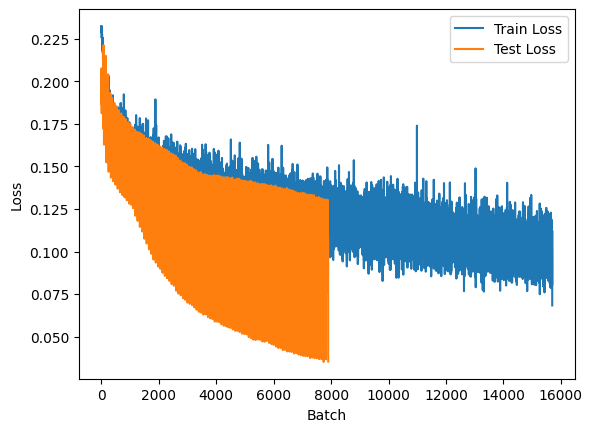

In [ ]:
model = neural_network(train_images, 32, device)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

n_epoch = 100
train_losses = []
test_losses = []

for epoch in trange(n_epoch):
  epoch_train_losses = []

  for batch_x, batch_y in trainloader:
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    batch_x = batch_x.view(batch_x.size(0), -1)

    loss = cross_entropy(model, batch_x, batch_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_losses.append(loss.item())
    epoch_train_losses.append(loss.item())


  epoch_test_losses = []
  for batch_x, batch_y in testloader:
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    batch_x = batch_x.view(batch_x.size(0), -1)

    loss = cross_entropy(model, batch_x, batch_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    test_losses.append(loss.item())
    epoch_test_losses.append(loss.item())

  if (epoch + 1) % 20 == 0:
    avg_train = np.mean(epoch_train_losses)
    avg_test = np.mean(epoch_test_losses)
    print(f'Epoch {epoch + 1} Average Train Batch Loss: {avg_train:.4f}')
    print(f'Epoch {epoch + 1} Average Test Batch Loss: {avg_test:.4f}')

plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

model.eval()

preds = []
targets = []

with torch.no_grad():
    for batch_x, batch_y in testloader:
        batch_x = batch_x.to(device).view(batch_x.size(0), -1)
        batch_y = batch_y.to(device)

        outputs = model(batch_x)

        _, predicted = torch.max(outputs, dim=1)

        preds.extend(predicted.cpu().numpy())
        targets.extend(batch_y.argmax(dim=1).cpu().numpy())

print(classification_report(targets, preds))


              precision    recall  f1-score   support

           0       0.74      0.71      0.72      1014
           1       0.81      0.80      0.80      1014
           2       0.56      0.51      0.53       952
           3       0.52      0.51      0.51      1016
           4       0.64      0.51      0.57       997
           5       0.50      0.47      0.48      1025
           6       0.64      0.74      0.69       980
           7       0.73      0.77      0.75       977
           8       0.77      0.83      0.80      1003
           9       0.71      0.80      0.75      1022

    accuracy                           0.67     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.67      0.66     10000



# Question 3 - Convnets (60 points)

Our next task is to fit a convolutional neural network (CNN) to CIFAR10. Again, we will construct one model "by hand" and one using all of the tools from pytorch. Because convolutions utilize spatial information, they tend to perform much better than MLPs. These models should work considerably better the MLP models above.

## part 1 - Transform the data (5 points)

In Question 2, we had to transform our data into vector form so that an MLP could use it. This time we want to keep the tensor form since a CNN expects tensor inputs, i.e. inputs shaped like (N, C, H, W). Perform the exact same data standardization as in Question 1, part 1, except __do not__ flatten the images. Make sure to create train loaders and test loaders again and do not shuffle the test data.

In [ ]:
# Numpy for algorithms using sklearn (ur welcome)
train_images = np.zeros((10 * 2000, 3, 32, 32))
train_labels = np.zeros((10 * 2000, 1))

for i in trange(len(train_data)):
  img, label = train_data[i]
  img = Normalize(0, 1)(img)
  img = (img - torch.mean(img))/torch.std(img)

  train_images[i] = img
  train_labels[i] = label

test_images = np.zeros((10 * 1000, 3,32,32))
test_labels = np.zeros((10 * 1000, 1))

for i in trange(len(test_data)):
  img, label = test_data[i]
  img = Normalize(0, 1)(img)
  img = (img - torch.mean(img))/torch.std(img)

  test_images[i] = img
  test_labels[i] = label

train_images = torch.tensor(train_images).float()
test_images = torch.tensor(test_images).float()

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(train_labels)

train_labels = torch.tensor(enc.transform(train_labels).toarray()).float()
test_labels = torch.tensor(enc.transform(test_labels).toarray()).float()

In [ ]:
# Dataloader for algorithms using pytorch
batch_size = 128

train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)

test_dataset = torch.utils.data.TensorDataset(test_images, test_labels)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle = False)

## part 2 - Convnets by hand-ish (20 points)

Now that we have our data in order for lets build our first CNN. To ensure we understand what an CNN does we will build this one without `nn.Conv2d()` and without using advanced optimization techniques like `optim.adam`. You may use classes to define your model and other torch functions like `nn.ReLU()` (See the neural network lectures for examples). You also may use `nn.functional.conv2d()` to apply conv filters and `nn.MaxPool2d()` or `nn.AvgPool2d()` for pooling.

Architecture requirements:
  1. Apply filter weights with `nn.functional.conv2d()` in your forward function
  2. Include a bias term in each layer
  3. Use at least 3 layers
  4. Use ReLU activation functions (except the last layer)
  4. Initialize your filter weights randomly around 0 (_hint: use a small variance_)

Loss requirements:
  1. Use an appropriate classification loss (_hint: make sure your model returns probabilities_)

Train requirements:
  1. Use a dataloader with a batch size < 150
  2. Update your weights and biases via gradient descent without using an optimizer function
  3. Train until test cross entropy < 0.15 (< 1.5 if use `nn.CrossEntropyLoss()`)
  4. Keep a train loss trace and a test loss trace

Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc.

In [ ]:
class convnet(nn.Module):
    def __init__(self):
      super(convnet, self).__init__()

      self.filters1 = nn.Parameter(torch.randn([16, 3, 3, 3])/10) ## 10 3x3x3 filters
      self.bias1 = nn.Parameter(torch.randn(16)/10)

      self.filters2 = nn.Parameter(torch.randn([32, 16, 3, 3])/20) ## 20 10x3x3 filters
      self.bias2 = nn.Parameter(torch.randn(32)/20)

      self.filters3 = nn.Parameter(torch.randn([64, 32, 3, 3])/20) ## 1 20x3x3 filters
      self.bias3 = nn.Parameter(torch.randn(64)/20)

      self.pool = torch.nn.MaxPool2d(2)

      self.weight4 = nn.Parameter(torch.randn([64*8*8, 10])/64)
      self.bias4 = nn.Parameter(torch.randn([1, 10])/4)

    def forward(self, x):
      # layer 1
      x = torch.nn.functional.conv2d(x, self.filters1, padding = 1)
      x = x + self.bias1[None,:,None,None]
      x = self.pool(x)
      x = torch.relu(x)

      # layer 2
      x = torch.nn.functional.conv2d(x, self.filters2, padding = 1)
      x = x + self.bias2[None,:,None,None]
      x = self.pool(x)
      x = torch.relu(x)

      # layer 3
      x = torch.nn.functional.conv2d(x, self.filters3, padding = 1)
      x = x + self.bias3[None,:,None,None]
      x = torch.relu(x)

      # output
      x = x.reshape(-1, 64*8*8)
      x = x @ self.weight4 + self.bias4
      x = torch.softmax(x, dim=1)
      return x

def cross_entropy(model, x, y):
  p = model(x)
  return -torch.mean(y * torch.log(p))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 Average Train Batch Loss: 0.2332
Epoch 2 Average Test Batch Loss: 0.2322
Epoch 4 Average Train Batch Loss: 0.2308
Epoch 4 Average Test Batch Loss: 0.2302
Epoch 6 Average Train Batch Loss: 0.2292
Epoch 6 Average Test Batch Loss: 0.2287
Epoch 8 Average Train Batch Loss: 0.2278
Epoch 8 Average Test Batch Loss: 0.2275
Epoch 10 Average Train Batch Loss: 0.2266
Epoch 10 Average Test Batch Loss: 0.2263


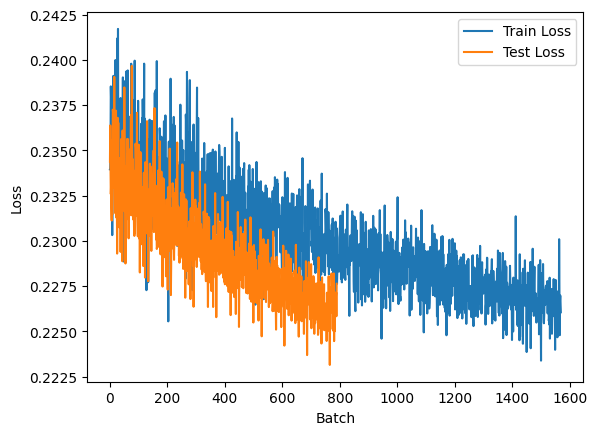

In [ ]:
model = convnet()
model.to(device)

n_epoch = 10
lr = 1e-3

train_losses = []
test_losses = []

for epoch in trange(n_epoch):
  epoch_train_losses = []

  for batch_x, batch_y in trainloader:

    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    loss = cross_entropy(model, batch_x, batch_y)
    loss.backward()

    model.filters1.data = model.filters1.data - lr * model.filters1.grad
    model.filters2.data = model.filters2.data - lr * model.filters2.grad
    model.filters3.data = model.filters3.data - lr * model.filters3.grad
    model.weight4.data = model.weight4.data - lr * model.weight4.grad

    model.bias1.data = model.bias1.data - lr * model.bias1.grad
    model.bias2.data = model.bias2.data - lr * model.bias2.grad
    model.bias3.data = model.bias3.data - lr * model.bias3.grad
    model.bias4.data = model.bias4.data - lr * model.bias4.grad

    model.filters1.grad.zero_()
    model.filters2.grad.zero_()
    model.filters3.grad.zero_()
    model.weight4.grad.zero_()

    model.bias1.grad.zero_()
    model.bias2.grad.zero_()
    model.bias3.grad.zero_()
    model.bias4.grad.zero_()

    epoch_train_losses.append(loss.item())
    train_losses.append(loss.item())

  epoch_test_losses = []

  for batch_x, batch_y in testloader:

    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    loss = cross_entropy(model, batch_x, batch_y)
    loss.backward()

    model.filters1.data = model.filters1.data - lr * model.filters1.grad
    model.filters2.data = model.filters2.data - lr * model.filters2.grad
    model.filters3.data = model.filters3.data - lr * model.filters3.grad
    model.weight4.data = model.weight4.data - lr * model.weight4.grad

    model.bias1.data = model.bias1.data - lr * model.bias1.grad
    model.bias2.data = model.bias2.data - lr * model.bias2.grad
    model.bias3.data = model.bias3.data - lr * model.bias3.grad
    model.bias4.data = model.bias4.data - lr * model.bias4.grad

    model.filters1.grad.zero_()
    model.filters2.grad.zero_()
    model.filters3.grad.zero_()
    model.weight4.grad.zero_()

    model.bias1.grad.zero_()
    model.bias2.grad.zero_()
    model.bias3.grad.zero_()
    model.bias4.grad.zero_()

    epoch_test_losses.append(loss.item())
    test_losses.append(loss.item())

  if (epoch + 1) % 2 == 0:
    avg_train = np.mean(epoch_train_losses)
    avg_test = np.mean(epoch_test_losses)
    print(f'Epoch {epoch + 1} Average Train Batch Loss: {avg_train:.4f}')
    print(f'Epoch {epoch + 1} Average Test Batch Loss: {avg_test:.4f}')



plt.plot( train_losses, label = 'Train Loss')
plt.plot(test_losses, label = "Test Loss")
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## part 3 - Convnets redux (20 points)


Now that we can write and train a CNN "by hand", lets use all of the convenience of pytorch to train a better one. This time you should construct your model using `nn.Conv2d()` and use a momentum based optimizer like `adam`. I will again include a few baseline requirements for your model and training procedure.

Model requirements:
  1. Include a bias term in each layer
  2. Use at least 3 layers
  3. Use ReLU activation functions (except the last layer)

Loss requirements:
  1. Use an appropriate classification loss (_hint: make sure your model returns probabilities_)

Train requirements:
  1. Use a dataloader with a batch size < 150
  2. Use the `adam` optimizer
  3. Train until test cross entropy < 0.15 (< 1.5 if use `nn.CrossEntropyLoss()`)
  4. Keep a train loss trace and a test loss trace


Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc. Compare these results to the ones you got in part 2.

_Hint: probably you can convert your model to double precision with `cnn = cnn.to(torch.float64)` if you encouter any related error_

In [ ]:
class convnet(nn.Module):
    def __init__(self):
      super(convnet, self).__init__()
      self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=True)
      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=True)
      self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=True)
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.global_avg = nn.AdaptiveAvgPool2d((1,1))
      self.fc = nn.Linear(128, 10)
      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim=1)
      self.device = device
      self.to(device)


    def forward(self, x):
      x = self.relu(self.conv1(x))
      x = self.pool(x)
      x = self.relu(self.conv2(x))
      x = self.pool(x)
      x = self.relu(self.conv3(x))
      x = self.pool(x)
      x = self.global_avg(x)
      x = x.view(x.size(0), -1)
      logits = self.fc(x)
      return logits


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 Average Train Batch Loss: 1.5967
Epoch 4 Average Train Batch Loss: 1.3656
Epoch 6 Average Train Batch Loss: 1.2456
Epoch 8 Average Train Batch Loss: 1.1482
Epoch 10 Average Train Batch Loss: 1.0597


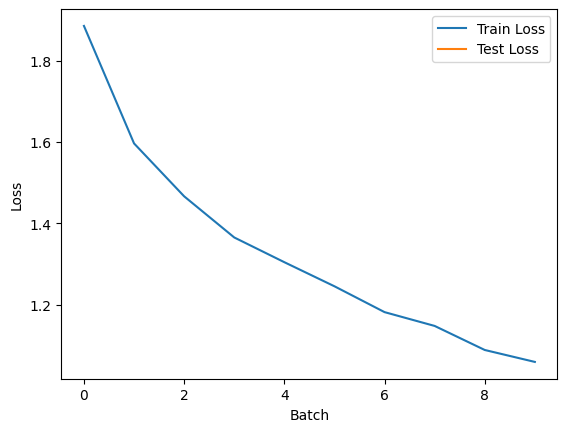

In [ ]:
#train
model = convnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
test_losses = []
epochs = 10

for epoch in trange(epochs):
    train_loss_total = 0.0
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        train_loss_total += loss.item()

    avg_train_loss = train_loss_total / len(trainloader)
    train_losses.append(avg_train_loss)
    if (epoch + 1) % 2 == 0:
      avg_train = np.mean(epoch_train_losses)
      avg_test = np.mean(epoch_test_losses)
      print(f'Epoch {epoch + 1} Average Train Batch Loss: {avg_train_loss:.4f}')

plt.plot( train_losses, label = 'Train Loss')
plt.plot(test_losses, label = "Test Loss")
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## part 4 - Additional Invariances (15 points)

Our CNN model can be trained to an impressively high degree of accuracy. However, although its robust to translations of the object in the image, its not robust to other forms of image ``noise''. Here we will consider two kinds of image corruption/noise that are irrelevant to the class of the object: Color inversion and Color jittering. You can see examples of this here under Photometric Transforms.
https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py


We will use a simple data augmentation strategy to encourage our model to be invariant to these two transformations.
1. Random color inversion
2. Random color jittering

You may find the following functions helpful for augmenting your training procedure
1. `torchvision.transforms.invert()`
2. `torchvision.transforms.ColorJitter()`

Demonstrate that your model is invariant to these transformation by comparing the test cross entropy and classification reports against
1. A standard CNN applied to randomly inverted and jittered images (you should have a much lower test loss and higher test F1s)
2. A standard CNN applied to uncorrupted images (you should have a comparable test loss and test F1)

In [ ]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F

aug_train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomInvert(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.02),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

aug_training_data = CIFAR10(root="data", train=True, download=True, transform=aug_train_transform)
standard_testing_data = CIFAR10(root="data", train=True, download=True, transform=test_transform)

aug_train_data = Subset(aug_training_data, range(0, 20000))
standard_test_data = Subset(standard_testing_data, range(40000, 50000))

aug_trainloader = DataLoader(aug_train_data, batch_size=128, shuffle=True)
standard_testloader = DataLoader(standard_test_data, batch_size=128, shuffle=False)

aug_cnn = convnet().to(device)
optimizer = Adam(aug_cnn.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

aug_train_losses, aug_test_losses = [], []
for epoch in range(10):
    aug_cnn.train()
    epoch_train_loss = []
    for bx, by in aug_trainloader:
        bx = bx.to(device)
        by = by.to(device)

        optimizer.zero_grad()
        logits = aug_cnn(bx)
        loss = criterion(logits, by)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())

    aug_train_losses.append(np.mean(epoch_train_loss))

    aug_cnn.eval()
    epoch_test_loss = []
    with torch.no_grad():
        for bx, by in standard_testloader:
            bx = bx.to(device)
            by = by.to(device)
            logits = aug_cnn(bx)
            loss = criterion(logits, by)
            epoch_test_loss.append(loss.item())
    aug_test_losses.append(np.mean(epoch_test_loss))
    print(f"Epoch {epoch + 1}/10 | Train Loss: {aug_train_losses[-1]:.4f} | Test Loss: {aug_test_losses[-1]:.4f}")

from sklearn.metrics import classification_report
aug_cnn.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for bx, by in standard_testloader:
        bx = bx.to(device)
        logits = aug_cnn(bx)
        preds = logits.argmax(dim=1).cpu()
        all_preds.append(preds)
        all_labels.append(by.cpu())

y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()

print("Classification Report after Augmented Training on Standard Test Images")
print(classification_report(y_true, y_pred, target_names=[f"class {i}" for i in range(10)]))


NameError: name 'Adam' is not defined